# Final project

## Reasearch questions

Which community split is best (born house or married house)?

Compare to the community split obtained by the algorithm.

Which communities are most connected?

Find sentiments score for each community.

Do the most connected communities have similar sentiment scores?

We wish to analyse the sentiments of each character and the average sentiment each community. The communities being the ones obtained by the algorithm and the ones obtained by splitting the houses, the religion and the cultures. We wish to compare the community splits and see which one is best. We also wish to see if the most connected communities have similar sentiment scores.

## Loading data


In [5]:
import pandas as pd
import networkx as nx
import os
import requests
import re
import numpy as np
import matplotlib.pyplot as plt
import powerlaw
import nltk
import requests
import community
import json

from scipy.stats import spearmanr
from scipy.stats import pearsonr
from scipy.stats import linregress

from nltk.corpus import PlaintextCorpusReader
from nltk import word_tokenize
from nltk import FreqDist
from wordcloud import WordCloud, STOPWORDS

In [7]:
if (not os.path.exists('files/names.csv')) or (not os.path.exists('files/houses.csv')) or (not os.path.exists('files/cultures.csv')) or (not os.path.exists('files/religions.csv')) or (not os.path.exists('files/wiki_texts/')) or (not os.path.exists('files/characters_houses.json')) or (not os.path.exists('files/characters_seasons.json')) or (not os.path.exists('files/characters_num_episodes.json')) or (not os.path.exists('files/characters_culture.json')) or (not os.path.exists('files/characters_religion.json')) or (not os.path.exists('files/characters_death.json')) or (not os.path.exists('files/characters.json')):
    # create paths
    if not os.path.exists('files'):
        os.mkdir('files')
    if not os.path.exists('files/wiki_texts'):
        os.mkdir('files/wiki_texts')

    baseurl = "https://gameofthrones.fandom.com/api.php?"

    pattern = r'\[{2}(.+?)\]{2}'
    word_pattern = r'\b\w+\b'

    site = 'Game_of_Thrones'
    params = {
        "action": "query",
        "prop": "revisions",
        "rvprop": "content",
        "format": "json",
        "titles": site
    }

    # Send the API request to retrieve the content
    response = requests.get(baseurl, params=params)
    data = response.json()

    # Extract and print the text content
    page_id = list(data['query']['pages'].keys())[0]
    text_content = data['query']['pages'][page_id]['revisions'][0]['*']
    cast = text_content[text_content.find("==Cast=="):text_content.find("==Crew==")]
    #print(cast)
    # find all lines starting with *
    lines = cast.split('\n')
    lines = [line for line in lines if line.startswith('*')]
    lines_chars = [line[line.find("as "):] for line in lines]
    # extract the second name in [[name]]
    pattern = r'\[{2}(.+?)\]{2}'
    names = [re.findall(pattern, line)[0] for line in lines_chars]
    names = [name.split('|')[0] for name in names]
    # remove Archmaester and add Ebrose
    names.remove('Archmaester')
    names.append('Ebrose')
    # remove khal and add Drogo
    names.remove('Khal')
    names.append('Drogo')
    # save names to csv
    names_df = pd.DataFrame(names, columns=['Name'])
    names_df.to_csv('files/names.csv', index=False)


    characters = {}
    #characters_houses = {}
    #characters_seasons = {}
    #characters_num_episodes = {}
    #characters_culture = {}
    #characters_religion = {}
    #characters_death = {}
    houses_list = []
    religions_list = []
    cultures_list = []
    for name in names:
        print(name)
        params = {
            "action": "query",
            "prop": "revisions",
            "rvprop": "content",
            "format": "json",
            "titles": name
        }

        # Send the API request to retrieve the content
        response = requests.get(baseurl, params=params)
        data = response.json()

        # Extract and print the text content
        page_id = list(data['query']['pages'].keys())[0]
        text_content = data['query']['pages'][page_id]['revisions'][0]['*']
        # save text content to file
        with open('files/wiki_texts/' + name + '.txt', 'w') as f:
            f.write(text_content)
        # find line with | House
        try:
            house_line = re.findall(r'\| House (.+)', text_content)[0]
            houses = re.findall(pattern, house_line)
            if len(houses) == 0:
                houses = ['No house']
        except:
            houses = ['No house']


        seasons_line = re.findall(r'\| Season (.+)', text_content)[0]
        seasons = re.findall(pattern, seasons_line)

        culture_line = re.findall(r'\| Culture (.+)', text_content)[0]
        culture = re.findall(pattern, culture_line)
        try:
            culture = culture[0].split('|')[0]
        except:
            culture = 'No culture'

        if culture not in cultures_list:
            cultures_list.append(culture)

        #characters_culture[name] = culture
        print(culture)

        #print(text_content)

        religion_line = re.findall(r'\| Religion (.+)', text_content)[0]
        religion = re.findall(pattern, religion_line)
        try:
            religion = religion[0].split('|')[0]
        except:
            religion = 'No religion'

        if religion not in religions_list:
            religions_list.append(religion)

        #characters_religion[name] = religion
        print(religion)

        death_line = re.findall(r'\| Death (.+)', text_content)[0]
        death = re.findall(pattern, death_line)
        try:
            death = death[0].split('|')[0].split(' ')
            death = int(death[0])
        except:
            death = -1 # not dead or unknown
        #characters_death[name] = death
        print(death)

        num_episodes = re.findall(r'\| Appearances (.+)', text_content)[0]
        num_episodes = num_episodes.split(' ')[1]
        try:
            num_episodes = int(num_episodes)
        except:
            num_episodes = 1
        print(num_episodes)

        #characters_houses[name] = []
        #characters_seasons[name] = []

        characters[name] = {'houses': [], 'seasons': [], 'num_episodes': num_episodes, 'culture': culture, 'religion': religion, 'death': death, 'tex_len': 0, 'sentiment': 0}
        for house in houses:
            house = house.split('|')[0]
            if house == 'Legitimization':
                continue
            if house == 'House Baratheon of King\'s Landing' or house == 'House Baratheon of Dragonstone':
                house = 'House Baratheon'
            if house not in houses_list:
                houses_list.append(house)
            if house not in characters[name]['houses']:
                #characters_houses[name].append(house)
                characters[name]['houses'].append(house)
        print(characters[name]['houses'])

        for season in seasons:
            season = season.split('|')[-1]
            #characters_seasons[name].append(int(season))
            characters[name]['seasons'].append(int(season))
        print(characters[name]['seasons'])

    """
    with open('files/characters_houses.json', 'w') as fp:
        json.dump(characters_houses, fp)
    with open('files/characters_seasons.json', 'w') as fp:
        json.dump(characters_seasons, fp)
    with open('files/characters_num_episodes.json', 'w') as fp:
        json.dump(characters_num_episodes, fp)
    with open('files/characters_culture.json', 'w') as fp:
        json.dump(characters_culture, fp)
    with open('files/characters_religion.json', 'w') as fp:
        json.dump(characters_religion, fp)
    with open('files/characters_death.json', 'w') as fp:
        json.dump(characters_death, fp)
    """
    with open('files/characters.json', 'w') as fp:
        json.dump(characters, fp)

    # save houses to csv
    houses_df = pd.DataFrame(houses_list, columns=['House'])
    houses_df.to_csv('files/houses.csv', index=False)

    cultures_df = pd.DataFrame(cultures_list, columns=['Culture'])
    cultures_df.to_csv('files/cultures.csv', index=False)

    religions_df = pd.DataFrame(religions_list, columns=['Religion'])
    religions_df.to_csv('files/religions.csv', index=False)
else:
    print('Loading characters and houses from files')
    """
    with open('files/characters_houses.json', 'r') as fp:
        characters_houses = json.load(fp)
    with open('files/characters_seasons.json', 'r') as fp:
        characters_seasons = json.load(fp)
    with open('files/characters_num_episodes.json', 'r') as fp:
        characters_num_episodes = json.load(fp)
    with open('files/characters_culture.json', 'r') as fp:
        characters_culture = json.load(fp)
    with open('files/characters_religion.json', 'r') as fp:
        characters_religion = json.load(fp)
    with open('files/characters_death.json', 'r') as fp:
        characters_death = json.load(fp)
    """
    with open('files/characters.json', 'r') as fp:
        characters = json.load(fp)

    houses_df = pd.read_csv('files/houses.csv')
    houses_list = list(houses_df['House'])

    names_df = pd.read_csv('files/names.csv')
    names = list(names_df['Name'])

    cultures_df = pd.read_csv('files/cultures.csv')
    cultures_list = list(cultures_df['Culture'])

    religions_df = pd.read_csv('files/religions.csv')
    religions_list = list(religions_df['Religion'])


Eddard Stark
Northmen
Old Gods of the Forest
298
19
['House Stark']
[1, 2, 3, 4, 6, 7]
Catelyn Stark
Riverlands
Faith of the Seven
300
26
['House Tully', 'House Stark']
[1, 2, 3, 6]
Robb Stark
Northmen
Faith of the Seven
300
23
['House Stark']
[1, 2, 3, 6]
Sansa Stark
Northmen
Faith of the Seven
-1
59
['House Stark', 'House Lannister', 'House Bolton']
[1, 2, 3, 4, 5, 6, 7, 8]
Arya Stark
Northmen
Old Gods of the Forest
-1
59
['House Stark']
[1, 2, 3, 4, 5, 6, 7, 8]
Bran Stark
Northmen
Old Gods of the Forest
-1
40
['House Stark']
[1, 2, 3, 4, 6, 7, 8]
Rickon Stark
Northmen
Old Gods of the Forest
303
14
['House Stark']
[1, 2, 3, 6]
Jon Snow
Northmen
Old Gods of the Forest
302
63
['House Targaryen']
[1, 2, 3, 4, 5, 6, 7, 8]
Benjen Stark
Northmen
Old Gods of the Forest
304
8
['House Stark']
[1, 6, 7]
Theon Greyjoy
Ironborn
Drowned God
305
47
['House Greyjoy']
[1, 2, 3, 4, 5, 6, 7, 8]
Rodrik Cassel
Northmen
No religion
299
15
['House Cassel']
[1, 2, 6]
Jory Cassel
Northmen
No religion
298
5


In [8]:
def get_sentiments(text, dict_avg):
    text_tokens = word_tokenize(text)
    text_words = [w.lower() for w in text_tokens if w.isalpha()]
    fdist = FreqDist(text_words)
    total_count = 0
    sentiment = 0
    for w in fdist:
        if w in dict_avg:
            sentiment += dict_avg[w]*fdist[w]
            total_count += fdist[w]
    if total_count == 0:
        return 0
    sentiment /= total_count
    return sentiment

In [9]:
df_happiness = pd.read_csv('files/LabMT.txt', sep='\t')
dict_avg_happiness = {}
for i in range(len(df_happiness)):
    dict_avg_happiness[df_happiness['word'][i]] = df_happiness['happiness_average'][i]

In [10]:
if (not os.path.exists('files/di_G.gexf')) or (not os.path.exists('files/di_G_with_houses.gexf')) or (not os.path.exists('files/characters_text_len.json')) or (not os.path.exists('files/characters_sentiment.json')):
    
    pattern = r'\[{2}(.+?)\]{2}'
    
    di_G = nx.DiGraph()
    di_G_with_house = nx.DiGraph()


    for name in names:
        houses = characters[name]['houses']
        first_house = houses[0]
        houses_string = ', '.join(houses)
        seasons = characters[name]['seasons']
        seasons_string = ', '.join([str(season) for season in seasons])
        first_season = seasons[0]
        last_season = seasons[-1]
        num_episodes = characters[name]['num_episodes']
        culture = characters[name]['culture']
        religion = characters[name]['religion']
        death = characters[name]['death']
        num_seasons = len(seasons)

        di_G.add_node(name, houses=houses_string, seasons=seasons_string, num_seasons=num_seasons, num_episodes=num_episodes, culture=culture, religion=religion, death=death, text_len=0, sentiment=0)

        if houses_string != 'No house':
            di_G_with_house.add_node(name, houses=houses_string, seasons=seasons_string, num_seasons=num_seasons, num_episodes=num_episodes, culture=culture, religion=religion, death=death, text_len=0, sentiment=0)

    #characters_text_len = {}
    #characters_sentiment = {}

    # add edges
    for name in names:
        # load text
        with open('files/wiki_texts/' + name + '.txt', 'r') as f:
            text = f.read()
        text_len = len(text)

        sentiment = get_sentiments(text, dict_avg_happiness)

        #characters_text_len[name] = text_len
        #characters_sentiment[name] = sentiment
        characters[name]['text_len'] = text_len
        characters[name]['sentiment'] = sentiment

        di_G.nodes[name]['text_len'] = text_len
        di_G.nodes[name]['sentiment'] = sentiment
        if name in di_G_with_house.nodes:
            di_G_with_house.nodes[name]['text_len'] = text_len
            di_G_with_house.nodes[name]['sentiment'] = sentiment

        # extract all links
        links = re.findall(pattern, text)
        # extract all links that are characters
        char_links = [link.split('|')[0] for link in links if link in names]
        # add edges
        for char_link in char_links:
            di_G.add_edge(name, char_link)

            if name in di_G_with_house.nodes and char_link in di_G_with_house.nodes != ['No house']:
                di_G_with_house.add_edge(name, char_link)

    G = di_G.to_undirected()
    G_with_house = di_G_with_house.to_undirected()

    print('All characters:')
    print(di_G)
    print('Number of connected components: ', nx.number_weakly_connected_components(di_G))
    print('Excluding charecters without houses:')
    print(di_G_with_house)
    print('Number of connected components: ', nx.number_weakly_connected_components(di_G_with_house))

    nx.write_gexf(di_G, "files/di_G.gexf")
    nx.write_gexf(di_G_with_house, "files/di_G_with_houses.gexf")
    """
    with open('files/characters_text_len.json', 'w') as fp:
        json.dump(characters_text_len, fp)

    with open('files/characters_sentiment.json', 'w') as fp:
        json.dump(characters_sentiment, fp)
    """
    with open('files/characters.json', 'w') as fp:
        json.dump(characters, fp)
else:
    print('Loading graphs from file')
    di_G = nx.read_gexf("files/di_G.gexf")
    di_G_with_house = nx.read_gexf("files/di_G_with_houses.gexf")
    G = di_G.to_undirected()
    G_with_house = di_G_with_house.to_undirected()

    """
    with open('files/characters_text_len.json', 'r') as fp:
        characters_text_len = json.load(fp)

    with open('files/characters_sentiment.json', 'r') as fp:
        characters_sentiment = json.load(fp)
    """

    with open('files/characters.json', 'r') as fp:
        characters = json.load(fp)

    print('All characters:')
    print(di_G)
    print('Number of connected components: ', nx.number_weakly_connected_components(di_G))
    print('Excluding charecters without houses:')
    print(di_G_with_house)
    print('Number of connected components: ', nx.number_weakly_connected_components(di_G_with_house))


All characters:
DiGraph with 221 nodes and 3719 edges
Number of connected components:  1
Excluding charecters without houses:
DiGraph with 114 nodes and 1908 edges
Number of connected components:  1


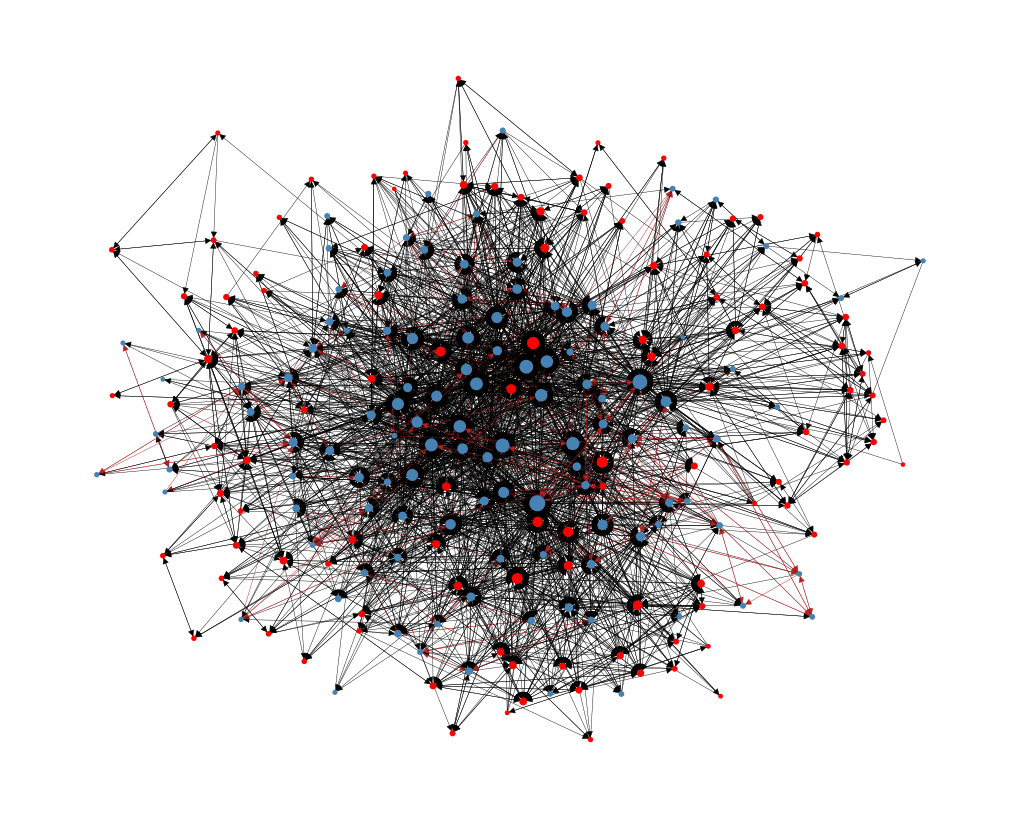

In [11]:
# make a color pallet for the houses
num_houses = len(houses_list)


colors = ['red' if di_G.nodes[node]['houses']=='No house' else 'steelblue' for node in di_G]


node_sizes = [di_G.in_degree(node)+5 for node in di_G]

edge_colors = []
for edge in di_G.edges():
    node_0 = di_G.nodes[edge[0]]
    node_1 = di_G.nodes[edge[1]]
    houses_0 = node_0['houses'].split(', ')
    houses_1 = node_1['houses'].split(', ')

    common_house = False
    for house_0 in houses_0:
        if house_0 in houses_1 and house_0 != 'No house':
            common_house = True
            break
    
    if common_house:
        edge_colors.append('firebrick')
    else:
        edge_colors.append('black')

plt.figure(figsize=(10, 8))
nx.draw_kamada_kawai(di_G, node_size=node_sizes, node_color=colors, edge_color=edge_colors, width=0.3, with_labels=False)
plt.show()

## Degree distributions

In [12]:
k_in = [di_G.in_degree(node) for node in di_G.nodes()]
k_out = [di_G.out_degree(node) for node in di_G.nodes()]
avg_k_in = np.mean(k_in)
avg_k_out = np.mean(k_out)
avg_k_in_sq = np.mean(np.square(k_in))
avg_k_out_sq = np.mean(np.square(k_out))

print("<k_in>", avg_k_in)
print("<k_out>", avg_k_out)

print("<k_in^2>", avg_k_in_sq)
print("<k_out^2>", avg_k_out_sq)

<k_in> 16.828054298642535
<k_out> 16.828054298642535
<k_in^2> 571.7692307692307
<k_out^2> 485.5429864253394


In [13]:
N = len(di_G.nodes())
print(f'lnN = {np.log(N)}')

lnN = 5.3981627015177525


super critical regime

min out-degree: 0
max out-degree: 105


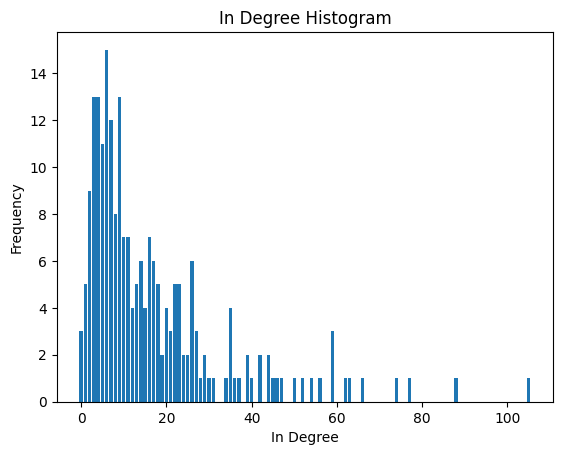

In [14]:
max_k_in = np.max(k_in)
min_k_in = np.min(k_in)
print(f'min out-degree: {min_k_in}')
print(f'max out-degree: {max_k_in}')
v = np.arange(min_k_in,max_k_in+2)

counts_in, bins_in = np.histogram(k_in, bins=v)
sum_counts_in = np.sum(counts_in)
plt.bar(bins_in[:-1], counts_in)

plt.title("In Degree Histogram")
plt.ylabel("Frequency")
plt.xlabel("In Degree")
plt.show()

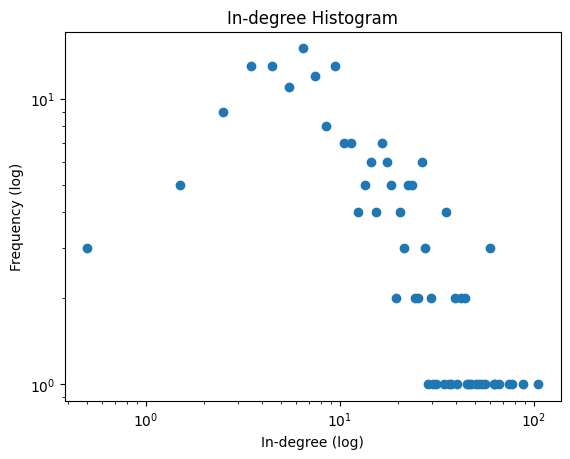

In [15]:
plt.loglog((bins_in[:-1]+bins_in[1:])/2, counts_in, 'o')

plt.title("In-degree Histogram")
plt.ylabel("Frequency (log)")
plt.xlabel("In-degree (log)")
plt.show()

min out-degree: 1
max out-degree: 75


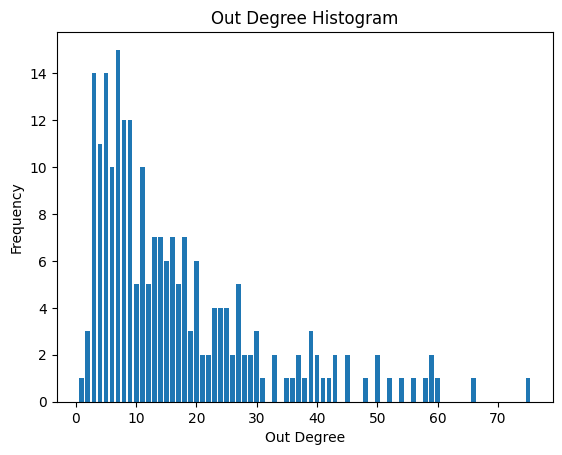

In [16]:
max_k_out = max(k_out)
min_k_out = min(k_out)
print(f'min out-degree: {min_k_out}')
print(f'max out-degree: {max_k_out}')
v = np.arange(min_k_out, max_k_out+2)

counts_out, bins_out = np.histogram(k_out, bins=v)
sum_counts_out = np.sum(counts_out)

plt.bar(bins_out[:-1], counts_out)
plt.title("Out Degree Histogram")
plt.xlabel("Out Degree")
plt.ylabel("Frequency")
plt.show()

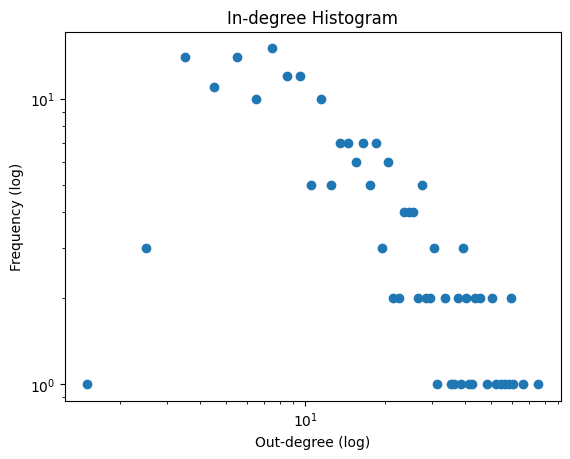

In [17]:
plt.loglog((bins_out[:-1]+bins_out[1:])/2, counts_out, 'o')

plt.title("In-degree Histogram")
plt.ylabel("Frequency (log)")
plt.xlabel("Out-degree (log)")
plt.show()

In [18]:
# Powerlaw
alpha_in = powerlaw.Fit(k_in).alpha
alpha_out = powerlaw.Fit(k_out).alpha

print(f'alpha in: {alpha_in}')
print(f'alpha out: {alpha_out}')

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
alpha in: 2.7021854011900404
alpha out: 3.0860797026662947


Values less than or equal to 0 in data. Throwing out 0 or negative values


### Ohter network statistics

In [19]:
# Get house sizes
house_sizes = {}
for house in houses_list:
    house_sizes[house] = 0

for name in names:
    houses = characters[name]['houses']
    for house in houses:
        house_sizes[house] += 1

# sort house sizes
house_sizes = dict(sorted(house_sizes.items(), key=lambda x: x[1], reverse=True))
print(house_sizes)

{'No house': 109, 'House Stark': 13, 'House Baratheon': 11, 'House Lannister': 9, 'House Targaryen': 7, 'House Frey': 6, 'House Tully': 5, 'House Greyjoy': 5, 'House Tarly': 5, 'House Bolton': 4, 'House Tyrell': 4, 'House Cassel': 3, 'House Umber': 3, 'House Karstark': 3, 'House Mormont': 3, 'House Reed': 3, 'House Martell': 3, 'House Payne': 2, 'House Clegane': 2, 'House Florent': 2, 'House Seaworth': 2, 'House Arryn': 2, 'House Baelish': 2, 'House Waynwood': 2, 'House Glover': 1, 'House Cerwyn': 1, 'House Manderly': 1, 'House Lorch': 1, 'House Tarth': 1, 'House Egen': 1, 'House Royce': 1, 'House Corbray': 1, 'House Redwyne': 1, 'House Kenning': 1, 'House Erenford': 1, "Bronn's house": 1, 'Maegyr family': 1, 'House Selmy': 1, 'House Trant': 1, 'House Dondarrion': 1, 'House Slynt': 1, 'House Stokeworth': 1, 'House Hollard': 1, 'House Thorne': 1, 'House Marsh': 1, 'House Yarwyck': 1, 'House Tollett': 1, 'House Mallister': 1, 'House Strickland': 1, 'House of Nakloz': 1, 'House of Ullhor'

In [20]:
# Get culture sizes
culture_sizes = {}
for culture in cultures_list:
    culture_sizes[culture] = 0

for name in names:
    culture = characters[name]['culture']
    culture_sizes[culture] += 1

# sort culture sizes
culture_sizes = dict(sorted(culture_sizes.items(), key=lambda x: x[1], reverse=True))
print(culture_sizes)

{'Andals': 47, 'Northmen': 37, 'No culture': 31, 'Free Folk': 10, 'Dothraki': 9, 'Ironborn': 8, 'Crownlands': 7, 'Dornishmen': 7, 'Ghiscari': 7, 'Westerlands': 6, 'Riverlands': 5, 'Valyrians': 5, 'Crannogmen': 4, 'Stormlands': 4, 'Reach': 4, 'Dornish Marches': 3, 'Volantis': 3, 'Braavos': 3, 'Asshai': 2, 'Summer Islands': 2, 'Vale of Arryn': 2, 'Lorath': 2, 'Lys': 2, 'Thenns': 2, 'Giants': 2, 'Yi Ti': 1, 'Norvos': 1, 'Westeros': 1, 'Hill tribes': 1, 'Myr': 1, 'Children of the Forest': 1, 'First Men': 1, 'Lhazar': 1, 'Pentos': 1, 'Lhazareen': 1, 'Naath': 1, 'Tyrosh': 1}


In [21]:
# Get religion sizes
religion_sizes = {}
for religion in religions_list:
    religion_sizes[religion] = 0

for name in names:
    religion = characters[name]['religion']
    religion_sizes[religion] += 1

# sort religion sizes
religion_sizes = dict(sorted(religion_sizes.items(), key=lambda x: x[1], reverse=True))
print(religion_sizes)

{'No religion': 85, 'Faith of the Seven': 61, 'Old Gods of the Forest': 43, "R'hllor": 9, 'Great Stallion': 9, 'Drowned God': 7, 'Ghiscari religion': 6, 'Many-Faced God': 3, 'Great Shepherd': 2, 'White Walkers': 1}


In [22]:
# average text lengths
text_lengths = [di_G.nodes[node]['text_len'] for node in di_G.nodes()]
avg_text_len = np.mean(text_lengths)
print(f'Average text length: {avg_text_len}')


# average text lengths for characters with houses
text_lengths_houses = [di_G_with_house.nodes[node]['text_len'] for node in di_G_with_house.nodes()]
avg_text_len_houses = np.mean(text_lengths_houses)
print(f'Average text length for characters with houses: {avg_text_len_houses}')

# average text lengths for characters without houses
text_lengths_no_houses = [di_G.nodes[node]['text_len'] for node in di_G.nodes() if di_G.nodes[node]['houses']=='No house']
avg_text_len_no_houses = np.mean(text_lengths_no_houses)
print(f'Average text length for characters without houses: {avg_text_len_no_houses}')

Average text length: 26481.60633484163
Average text length for characters with houses: 37854.69298245614
Average text length for characters without houses: 14364.485981308411


In [23]:
k_in = di_G.in_degree
k_out = di_G.out_degree
print(sorted(k_in, key=lambda x: x[1], reverse=True)[:5])
print(sorted(k_out, key=lambda x: x[1], reverse=True)[:5])

# weighted degrees by text length
k_in_weighted = sorted([(node, di_G.in_degree[node]/di_G.nodes[node]['text_len']) for node in di_G.nodes()], key=lambda x: x[1], reverse=True)
k_out_weighted = sorted([(node, di_G.out_degree[node]/di_G.nodes[node]['text_len']) for node in di_G.nodes()], key=lambda x: x[1], reverse=True)

print(k_in_weighted[:5])
print(k_out_weighted[:5])

[('Jon Snow', 105), ('Daenerys Targaryen', 88), ('Eddard Stark', 77), ('Tyrion Lannister', 74), ('Stannis Baratheon', 66)]
[('Jon Snow', 75), ('Tyrion Lannister', 66), ('Jaime Lannister', 60), ('Sansa Stark', 59), ('Arya Stark', 59)]
[('Ned Umber', 0.0021966880702940185), ('Prendahl na Ghezn', 0.00208955223880597), ('Mago', 0.002065049044914817), ('Amory Lorch', 0.0018250134192163178), ('Anya Waynwood', 0.0017220172201722018)]
[('Wolkan', 0.0023745612223828204), ('Gerold Hightower', 0.0019214932747735384), ('Caleotte', 0.001782001782001782), ('Old Nan', 0.0017507002801120449), ('Robett Glover', 0.001665657177468201)]


correlation coefficient: 0.9038735208404967
correlation coefficient: 0.9171203608139445
slope: 1991.9743667288433
intercept: -7039.446469975424
r_value: 0.9171203608139438


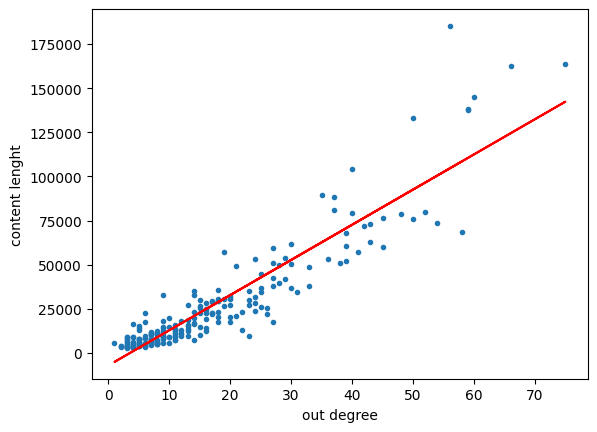

In [24]:
# check correlation between out degree and content length
content_lenght = np.array([d for n, d in di_G.nodes(data='text_len')])
k_out_array = np.array([d for n, d in k_out])

# calculate spearman correlation coefficient
corr, p = spearmanr(k_out_array, content_lenght)
print(f'correlation coefficient: {corr}')

# calculate pearson correlation coefficient
corr, p = pearsonr(k_out_array, content_lenght)
print(f'correlation coefficient: {corr}')

# fit line to data
slope, intercept, r_value, p_value, std_err = linregress(k_out_array, content_lenght)
print(f'slope: {slope}')
print(f'intercept: {intercept}')
print(f'r_value: {r_value}')

plt.plot(k_out_array, content_lenght, '.')
plt.plot(k_out_array, intercept + slope*k_out_array, 'r', label='fitted line')
plt.xlabel('out degree')
plt.ylabel('content lenght')
plt.show()


In [25]:
centrality = nx.degree_centrality(G)
betweenness = nx.betweenness_centrality(G)
eigenvector = nx.eigenvector_centrality(G)

centrality = dict(sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:5])
betweenness = dict(sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:5])
eigenvector = dict(sorted(eigenvector.items(), key=lambda x: x[1], reverse=True)[:5])
print(centrality)
print(betweenness)
print(eigenvector)

{'Jon Snow': 0.5045454545454545, 'Tyrion Lannister': 0.42727272727272725, 'Daenerys Targaryen': 0.41818181818181815, 'Eddard Stark': 0.39999999999999997, 'Sansa Stark': 0.3727272727272727}
{'Daenerys Targaryen': 0.11239286778749949, 'Jon Snow': 0.10053199606988947, 'Tyrion Lannister': 0.06379067034518995, 'Arya Stark': 0.05685853589905729, 'Eddard Stark': 0.04416247284325617}
{'Jon Snow': 0.19199763533967917, 'Tyrion Lannister': 0.18668418429321545, 'Eddard Stark': 0.17729375334231987, 'Sansa Stark': 0.1765710126878478, 'Jaime Lannister': 0.17455065486419988}


In [26]:
r_degree = nx.degree_assortativity_coefficient(di_G)
print(f'assortativity coefficient: {r_degree}')
r_degree = nx.degree_assortativity_coefficient(G)
print(f'assortativity coefficient: {r_degree}')

assortativity coefficient: -0.05766495686929051
assortativity coefficient: -0.07844455749727569


In [27]:
r_content_lenght = nx.attribute_assortativity_coefficient(di_G, 'text_len')
print(f'assortativity coefficient: {r_content_lenght}')
r_content_lenght = nx.attribute_assortativity_coefficient(G, 'text_len')
print(f'assortativity coefficient: {r_content_lenght}')

assortativity coefficient: -0.008075486561239353
assortativity coefficient: -0.008017543539508438


In [28]:
r_houses = nx.attribute_assortativity_coefficient(di_G, 'houses')
print(f'assortativity coefficient: {r_houses}')
r_houses = nx.attribute_assortativity_coefficient(G, 'houses')
print(f'assortativity coefficient: {r_houses}')

assortativity coefficient: 0.06682564325080888
assortativity coefficient: 0.05379174486368499


In [29]:
# average shortest path length
avg_d = nx.average_shortest_path_length(G)
print(f'average shortest path length: {avg_d}')

G_ER = nx.erdos_renyi_graph(len(G.nodes()), nx.density(G))
avg_d_ER = nx.average_shortest_path_length(G_ER)
print(f'average shortest path length: {avg_d_ER}')

average shortest path length: 2.1522830111065403
average shortest path length: 1.9786096256684491


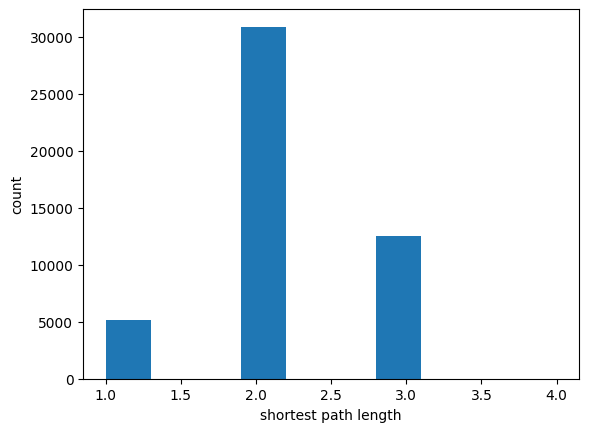

In [30]:
# plot distribution over shortest path lengths
d = []
for node1 in G.nodes():
    for node2 in G.nodes():
        if node1 != node2:
            d.append(nx.shortest_path_length(G, node1, node2))
plt.hist(d)
plt.xlabel('shortest path length')
plt.ylabel('count')
plt.show()

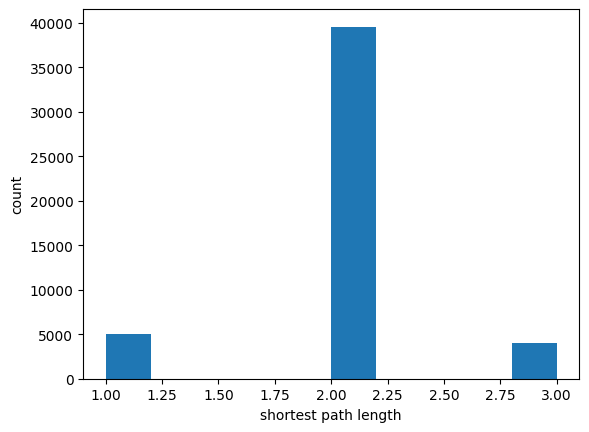

In [31]:
# plot distribution over shortest path lengths
d = []
for node1 in G_ER.nodes():
    for node2 in G_ER.nodes():
        if node1 != node2:
            d.append(nx.shortest_path_length(G_ER, node1, node2))

plt.hist(d)
plt.xlabel('shortest path length')
plt.ylabel('count')
plt.show()


## Word clouds

In [32]:
houses_file_names = []
no_houses_file_names = []
for node in di_G.nodes():
    # save text to file
    file_name = node + '.txt'
    houses = di_G.nodes[node]['houses']
    if houses == 'No house':
        no_houses_file_names.append(file_name)
    else:
        houses_file_names.append(file_name)

houses_corpus = PlaintextCorpusReader('files/wiki_texts', houses_file_names)

no_houses_corpus = PlaintextCorpusReader('files/wiki_texts', no_houses_file_names)

houses_raw = houses_corpus.raw()
no_houses_raw = no_houses_corpus.raw()


In [33]:
def lexical_diversity(text):
    return len(set(text)) / len(text)
    
def percentage(count, total):
    return 100 * count / total

def vocab_size(text):
    return len(set(text))

In [34]:
print(lexical_diversity(houses_raw))
print(lexical_diversity(no_houses_raw))
print(vocab_size(houses_raw))
print(vocab_size(no_houses_raw))

8.885745882400606e-05
0.0002178914681307942
386
338


In [35]:
def plot_zipf(text):
    req_dist = FreqDist(text)
    counts = []
    for word in req_dist:
        counts.append(req_dist[word])
    plt.figure()
    plt.loglog(counts)
    plt.show()

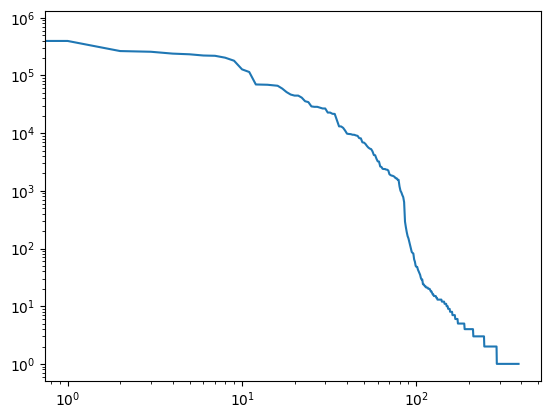

In [36]:
plot_zipf(houses_raw)

In [37]:
def get_TFTR(text1, text2, c = 1, weighted = False):

    stopwords = nltk.corpus.stopwords.words('english')

    text1_tokens = word_tokenize(text1)
    text1_words = [w.lower() for w in text1_tokens if (w.lower().isalpha() and w.lower() not in stopwords)]

    text2_tokens = word_tokenize(text2)
    text2_words = [w.lower() for w in text2_tokens if (w.lower().isalpha() and w.lower() not in stopwords)]
    
    if weighted:
        #r1 = len(text2_words)/len(text1_words)
        #r2 = len(text1_words)/len(text2_words)
        r1 = 1/len(text1_words)
        r2 = 1/len(text2_words)
    else:
        r1 = 1
        r2 = 1

    fdist1 = FreqDist(text1_words)
    fdist2 = FreqDist(text2_words)

    dict1_TFTR = dict()
    dict2_TFTR = dict()

    for w in fdist1:
        if w in fdist2:
            weight1 = fdist1[w]*r1/(fdist2[w]*r2+c)
        else:
            weight1 = fdist1[w]*r1/c
        dict1_TFTR[w] = weight1*fdist1[w]
        
    for w in fdist2:
        if w in fdist1:
            weight2 = fdist2[w]*r2/(fdist1[w]*r1+c)
        else:
            weight2 = fdist2[w]*r2/c
        dict2_TFTR[w] = weight2*fdist2[w]

    dict1_TFTR = dict(sorted(dict1_TFTR.items(), key=lambda x:x[1], reverse=True))
    dict2_TFTR = dict(sorted(dict2_TFTR.items(), key=lambda x:x[1], reverse=True))

    return dict1_TFTR, dict2_TFTR, fdist1, fdist2


In [38]:
dict_houses_TFTR, dict_no_houses_TFTR, fdist_houses, fdist_no_houses = get_TFTR(houses_raw, no_houses_raw, c = 1)

houses_str = ""
no_houses_str = ""

for w in dict_houses_TFTR:
    for i in range(int(dict_houses_TFTR[w])):
        houses_str += w + " "

for w in dict_no_houses_TFTR:
    for i in range(int(dict_no_houses_TFTR[w])):
        no_houses_str += w + " "

dict_houses_TFTR_weighted, dict_no_houses_TFTR_weighted, _, _ = get_TFTR(houses_raw, no_houses_raw, c = 1, weighted=True)

houses_str_weighted = ""
no_houses_str_weighted = ""

for w in dict_houses_TFTR_weighted:
    for i in range(int(dict_houses_TFTR_weighted[w])):
        houses_str_weighted += w + " "

for w in dict_no_houses_TFTR_weighted:
    for i in range(int(dict_no_houses_TFTR_weighted[w])):
        no_houses_str_weighted += w + " "

In [39]:
print("Top 5 words in the text from the characters with houses")
for i, w in enumerate(fdist_houses):
    if i >= 10:
        break
    print(w, fdist_houses[w])
    

print("\nTop 5 TF-TR scores in the text from the characters with houses")
for i, w in enumerate(dict_houses_TFTR):
    if i >= 10:
        break
    print(w, dict_houses_TFTR[w])

print("\nTop 5 weighted TF-TR scores in the text from the characters with houses")
for i, w in enumerate(dict_houses_TFTR_weighted):
    if i >= 10:
        break
    print(w, dict_houses_TFTR_weighted[w])


print("\nTop 5 words in the text from the characters with no house")
for i, w in enumerate(fdist_no_houses):
    if i >= 10:
        break
    print(w, fdist_no_houses[w])
    
        
print("\nTop 5 TF-TR scores in the text from the characters with no house")
for i, w in enumerate(dict_no_houses_TFTR):
    if i >= 10:
        break
    print(w, dict_no_houses_TFTR[w])

print("\nTop 5 weighted TF-TR scores in the text from the characters with no house")
for i, w in enumerate(dict_no_houses_TFTR_weighted):
    if i >= 10:
        break
    print(w, dict_no_houses_TFTR_weighted[w])
    

Top 5 words in the text from the characters with houses
jon 3275
king 2596
house 2569
tyrion 2540
season 2395
cersei 2179
sansa 2170
daenerys 2124
jaime 2098
stark 2035

Top 5 TF-TR scores in the text from the characters with houses
rhaegar 33153.125
robb 29835.57142857143
kingsguard 21395.571428571428
lyanna 21120.363636363636
jaime 20860.682464454974
sansa 19378.189300411523
joffrey 16785.81081081081
robert 15217.814814814814
stark 12325.074404761905
catelyn 11880.692307692307

Top 5 weighted TF-TR scores in the text from the characters with houses
jon 29.635276750391483
king 18.665801573072386
house 18.299779445728777
tyrion 17.873247100044072
season 15.81148943212146
cersei 13.180445244060198
sansa 13.090821584928864
daenerys 12.472308410505995
jaime 12.239615761586313
stark 11.504255887636196

Top 5 words in the text from the characters with no house
season 1325
thrones 1282
game 1226
jon 1023
daenerys 949
king 714
tyrion 685
night 646
file 643
house 573

Top 5 TF-TR scores in the

In [40]:
dict_Stark_TFTR, dict_no_houses_TFTR, fdist_houses, fdist_no_houses = get_TFTR(houses_raw, no_houses_raw, c = 1)

houses_str = ""
no_houses_str = ""

for w in dict_houses_TFTR:
    for i in range(int(dict_houses_TFTR[w])):
        houses_str += w + " "

for w in dict_no_houses_TFTR:
    for i in range(int(dict_no_houses_TFTR[w])):
        no_houses_str += w + " "

dict_houses_TFTR_weighted, dict_no_houses_TFTR_weighted, _, _ = get_TFTR(houses_raw, no_houses_raw, c = 1, weighted=True)

houses_str_weighted = ""
no_houses_str_weighted = ""

for w in dict_houses_TFTR_weighted:
    for i in range(int(dict_houses_TFTR_weighted[w])):
        houses_str_weighted += w + " "

for w in dict_no_houses_TFTR_weighted:
    for i in range(int(dict_no_houses_TFTR_weighted[w])):
        no_houses_str_weighted += w + " "

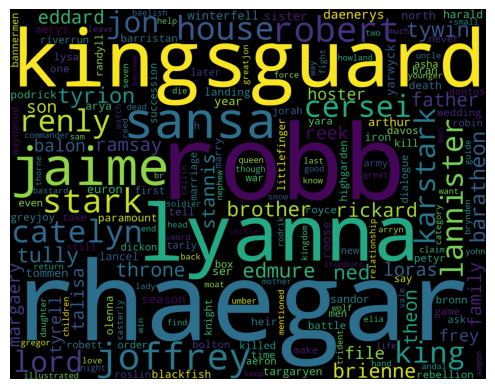

In [41]:
houses_wordcloud = WordCloud(
                      stopwords=STOPWORDS,
                      background_color='black',
                      width=1800,
                      height=1400,
                      collocations = False
                     ).generate(houses_str)

plt.imshow(houses_wordcloud)
plt.axis('off')
plt.show()

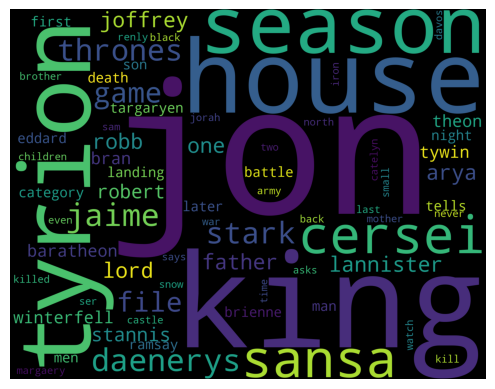

In [42]:
houses_wordcloud_weighted = WordCloud(
                      stopwords=STOPWORDS,
                      background_color='black',
                      width=1800,
                      height=1400,
                      collocations = False
                     ).generate(houses_str_weighted)

plt.imshow(houses_wordcloud_weighted)
plt.axis('off')
plt.show()

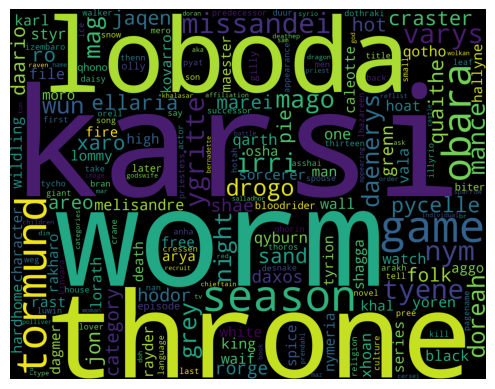

In [43]:
no_houses_wordcloud = WordCloud(
                      stopwords=STOPWORDS,
                      background_color='black',
                      width=1800,
                      height=1400,
                      collocations = False
                     ).generate(no_houses_str)

plt.imshow(no_houses_wordcloud)
plt.axis('off')
plt.show()

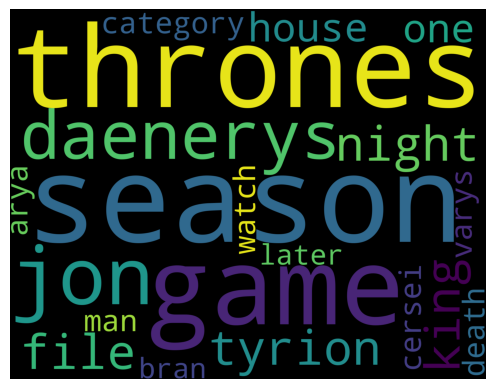

In [44]:
no_houses_wordcloud_weighted = WordCloud(
                      stopwords=STOPWORDS,
                      background_color='black',
                      width=1800,
                      height=1400,
                      collocations = False
                     ).generate(no_houses_str_weighted)

plt.imshow(no_houses_wordcloud_weighted)
plt.axis('off')
plt.show()

## Communities

In [45]:
best_partition = community.best_partition(G, random_state = 42)
print(f'Number of communities: {len(set(best_partition.values()))}')

Number of communities: 6


In [46]:
best_M = community.modularity(best_partition, G)
print(best_M)

0.3358652574965447


In [47]:
count_best_communities = dict(FreqDist(list(best_partition.values())))
count_best_communities = dict(sorted(count_best_communities.items(), key=lambda x:x[1], reverse=True))
print(count_best_communities)

{4: 56, 1: 52, 5: 45, 2: 35, 3: 24, 0: 9}


In [48]:
birth_house_partition = {}
dict_houses = {}
for i, house in enumerate(houses_list):
    dict_houses[house] = i

for node in G.nodes():
    birth_house = G.nodes[node]['houses'].split(', ')[0]
    birth_house_partition[node] = dict_houses[birth_house]
    
birth_house_M = community.modularity(birth_house_partition, G)
print(birth_house_M)

0.052507812030527026


In [49]:
last_house_partition = {}
dict_houses = {}
for i, house in enumerate(houses_list):
    dict_houses[house] = i

for node in G.nodes():
    last_house = G.nodes[node]['houses'].split(', ')[-1]
    last_house_partition[node] = dict_houses[last_house]
    
last_house_M = community.modularity(last_house_partition, G)
print(last_house_M)

0.05651523345952769


In [50]:
second_house_partition = {}
dict_houses = {}
for i, house in enumerate(houses_list):
    dict_houses[house] = i

for node in G.nodes():
    try:
        second_house = G.nodes[node]['houses'].split(', ')[1]
    except:
        second_house = G.nodes[node]['houses']
    second_house_partition[node] = dict_houses[second_house]
    
second_house_M = community.modularity(second_house_partition, G)
print(second_house_M)

0.05561775133705908


In [51]:
culture_partition = {}
dict_cultures = {}
for i, culture in enumerate(cultures_list):
    dict_cultures[culture] = i

for node in G.nodes():
    culture = G.nodes[node]['culture']
    culture_partition[node] = dict_cultures[culture]
    
culture_M = community.modularity(culture_partition, G)
print(culture_M)

0.06231258638302985


In [52]:
religion_partition = {}
dict_religions = {}
for i, religion in enumerate(religions_list):
    dict_religions[religion] = i

for node in G.nodes():
    religion = G.nodes[node]['religion']
    religion_partition[node] = dict_religions[religion]
    
religion_M = community.modularity(religion_partition, G)
print(religion_M)

0.07787107145003307


# Sentiments

In [53]:
all_corpus = PlaintextCorpusReader('files/wiki_texts', '.*')

> We then define a function to calculate the sentiments of a raw text given a dictionary of words and their corresponding average sentiment.

In [55]:
characters_sentiments = {}
for name in names:
    characters_sentiments[name] = characters[name]['sentiment']

sentiments=dict(sorted(characters_sentiments.items(), key=lambda x:x[1], reverse=True))
print(sentiments)

{'Talla Tarly': 5.529004854368929, 'Walda Bolton': 5.521348511383533, 'Melessa Tarly': 5.510585858585858, 'Roslin Tully': 5.505944309927355, 'Bernadette': 5.495778688524588, 'Ternesio Terys': 5.481174698795179, 'Moro': 5.467292724196272, 'Kitty Frey': 5.4630616740088085, 'Joyeuse Frey': 5.462453987730059, 'Anya Waynwood': 5.458746666666665, 'Lollys Stokeworth': 5.457144970414198, 'Leaf': 5.449579684763569, 'Donnel Waynwood': 5.433333333333334, 'High Septon (Joffrey)': 5.428569051580697, 'Steelshanks': 5.4272631578947355, 'Prendahl na Ghezn': 5.426723549488054, 'Matthos Seaworth': 5.425050125313277, 'Selyse Baratheon': 5.424962025316458, 'Zanrush': 5.420472440944881, 'Lyanna Stark': 5.41957794034891, 'Ros': 5.413762096774191, 'Caleotte': 5.41016501650165, 'Marei': 5.40864636209813, 'Vance Corbray': 5.405808580858083, 'Lothar Frey': 5.404445488721796, 'Tycho Nestoris': 5.400397140587768, 'Dim Dalba': 5.39978873239437, 'Shireen Baratheon': 5.397005907626205, 'Walder Frey': 5.3963064889918

5.529004854368929
5.169454094292797


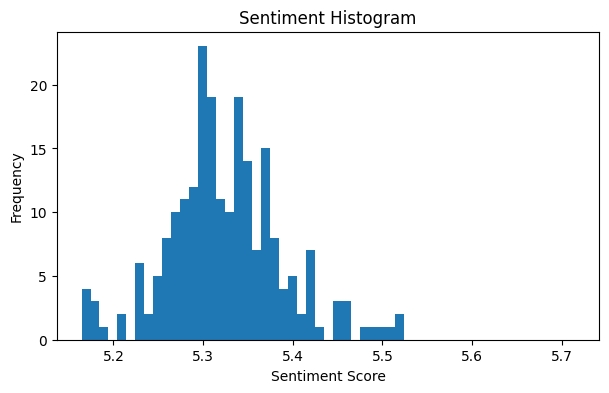

In [57]:
sentiments_list = list(sentiments.values())
max_s = max(sentiments_list)
min_s = min(sentiments_list)
print(max_s)
print(min_s)

v = np.arange(min_s, max_s + 0.2, 0.01)

s_counts, s_bins = np.histogram(sentiments_list, bins=v)

plt.figure(figsize=(7,4))
plt.bar(s_bins[:-1], s_counts, width=np.diff(s_bins))
plt.title("Sentiment Histogram")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.show()

In [59]:
houses_sentiment = {}

# initialize house sentiments and size to 0
for house in houses_list:
    houses_sentiment[house] = 0

# Calculate the total sentiment
for node, attributes in di_G.nodes(data=True):
    all_houses = attributes['houses'].split(', ')

    sentiment = sentiments[node]
    
    for house in all_houses:
        houses_sentiment[house] += sentiment


# Calculate the average sentiment
for house in houses_list:
    size = house_sizes[house]
    houses_sentiment[house] /= size

print(sorted(houses_sentiment.items(), key=lambda x: x[1], reverse=True))

[('House Florent', 5.467773941951158), ('House Erenford', 5.462453987730059), ('House Frey', 5.458926743460572), ('House Stokeworth', 5.457144970414198), ('House Waynwood', 5.446039999999999), ('House Corbray', 5.405808580858083), ('House Tarly', 5.397280115908376), ('House Royce', 5.37881475341897), ('House Egen', 5.377577937649873), ('House Tully', 5.375795399527197), ('Maegyr family', 5.37512898330804), ('House Bolton', 5.373667017910263), ('House Arryn', 5.3694328498013295), ('House Redwyne', 5.368031286403727), ('House Tyrell', 5.367440321594062), ('House Seaworth', 5.363488812519751), ('House Yarwyck', 5.354039688164422), ('House Strickland', 5.3530851063829745), ('House Cerwyn', 5.351469594594592), ('House Mallister', 5.347740458015266), ('House Tarth', 5.347262247838614), ('House Reed', 5.346699111566527), ('House Baratheon', 5.346467796664303), ('House Baelish', 5.344728969405199), ('House Marsh', 5.343559498956155), ('House Mormont', 5.339139420349153), ('House Targaryen', 5.

In [60]:
culture_sentiment = {}

# initialize house sentiments and size to 0
for culture in cultures_list:
    culture_sentiment[culture] = 0

# Calculate the total sentiment
for node, attributes in di_G.nodes(data=True):
    culture = attributes['culture']
    culture_sentiment[culture] += sentiments[node]

# Calculate the average sentiment
for culture in cultures_list:
    size = culture_sizes[culture]
    culture_sentiment[culture] /= size

print(sorted(culture_sentiment.items(), key=lambda x: x[1], reverse=True))

[('Children of the Forest', 5.449579684763569), ('Reach', 5.387168193793721), ('Volantis', 5.386662282451201), ('Yi Ti', 5.381330357142848), ('Pentos', 5.370104477611942), ('Vale of Arryn', 5.357579167815372), ('Riverlands', 5.353867835340102), ('Lorath', 5.346735771837086), ('Crownlands', 5.346145788856515), ('Crannogmen', 5.345914208413934), ('Asshai', 5.34564094239435), ('Andals', 5.338390446371139), ('Norvos', 5.337888949972509), ('No culture', 5.336249890613968), ('Valyrians', 5.324256628555807), ('Dornishmen', 5.323550568733509), ('Dothraki', 5.322957853108701), ('Braavos', 5.322469708063044), ('Hill tribes', 5.32209302325582), ('Lys', 5.321923659948212), ('Lhazareen', 5.320478723404249), ('Stormlands', 5.319976378977023), ('First Men', 5.319073183084333), ('Free Folk', 5.31688500955278), ('Westeros', 5.311550734779562), ('Myr', 5.309798732761829), ('Ghiscari', 5.308755105480269), ('Lhazar', 5.300140056022408), ('Ironborn', 5.29969812046676), ('Summer Islands', 5.297512111327162)

In [61]:
religion_sentiment = {}

# initialize house sentiments and size to 0
for religion in religions_list:
    religion_sentiment[religion] = 0

# Calculate the total sentiment
for node, attributes in di_G.nodes(data=True):
    religion = attributes['religion']
    religion_sentiment[religion] += sentiments[node]

# Calculate the average sentiment
for religion in religions_list:
    size = religion_sizes[religion]
    religion_sentiment[religion] /= size

print(sorted(religion_sentiment.items(), key=lambda x: x[1], reverse=True))

[("R'hllor", 5.345551209714973), ('Faith of the Seven', 5.3404759722785435), ('Great Stallion', 5.322957853108701), ('Great Shepherd', 5.310309389713328), ('White Walkers', 5.3095258078052865), ('Many-Faced God', 5.300979816004086), ('Drowned God', 5.299376138622241), ('Ghiscari religion', 5.2890936981456385), ('No religion', 5.2046333470989286), ('Old Gods of the Forest', 4.952842034181191)]
